In [1]:
!pip install tensorflow matplotlib


In [2]:
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

# Traffic Environment (simplified)
class TrafficEnv:
    def __init__(self):
        self.max_steps = 50
        self.reset()

    def reset(self):
        self.state = np.random.randint(0, 10, size=4)
        self.time_step = 0
        return self.state.copy()

    def step(self, action):
        reward = 0
        cars_through = 0

        if action == 0:  # N-S green
            cars_through = min(self.state[0], 3) + min(self.state[2], 3)
            self.state[0] -= min(self.state[0], 3)
            self.state[2] -= min(self.state[2], 3)
        elif action == 1:  # E-W green
            cars_through = min(self.state[1], 3) + min(self.state[3], 3)
            self.state[1] -= min(self.state[1], 3)
            self.state[3] -= min(self.state[3], 3)

        self.state += np.random.randint(0, 3, size=4)  # Add new cars
        reward += cars_through - 0.2 * np.sum(self.state)  # Encourage flow, discourage congestion

        self.time_step += 1
        done = self.time_step >= self.max_steps
        return self.state.copy(), reward, done

# DQN Agent
class DQNAgent:
    def __init__(self):
        self.state_size = 4
        self.action_size = 2
        self.memory = deque(maxlen=1000)
        self.gamma = 0.9
        self.epsilon = 1.0
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.95
        self.batch_size = 32
        self.model = self.build_model()

    def build_model(self):
        model = tf.keras.Sequential([
            layers.Dense(32, input_dim=4, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(2, activation='linear')
        ])
        model.compile(optimizer='adam', loss='mse')
        return model

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return random.randrange(2)
        return np.argmax(self.model.predict(state[np.newaxis], verbose=0)[0])

    def remember(self, s, a, r, s_, done):
        self.memory.append((s, a, r, s_, done))

    def train(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        for s, a, r, s_, done in batch:
            target = r
            if not done:
                target += self.gamma * np.amax(self.model.predict(s_[np.newaxis], verbose=0)[0])
            target_f = self.model.predict(s[np.newaxis], verbose=0)
            target_f[0][a] = target
            self.model.fit(s[np.newaxis], target_f, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


In [3]:
env = TrafficEnv()
agent = DQNAgent()
episodes = 10
rewards = []

for ep in range(episodes):
    state = env.reset()
    total_reward = 0
    while True:
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        agent.train()
        state = next_state
        total_reward += reward
        if done:
            break
    rewards.append(total_reward)
    print(f"Episode {ep+1}: Total Reward = {total_reward:.2f}, Epsilon = {agent.epsilon:.2f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Episode 1: Total Reward = 70.20, Epsilon = 0.38
Episode 2: Total Reward = -53.60, Epsilon = 0.10
Episode 3: Total Reward = 102.60, Epsilon = 0.10
Episode 4: Total Reward = 126.20, Epsilon = 0.10
Episode 5: Total Reward = 116.60, Epsilon = 0.10
Episode 6: Total Reward = 131.00, Epsilon = 0.10
Episode 7: Total Reward = 118.20, Epsilon = 0.10
Episode 8: Total Reward = 129.80, Epsilon = 0.10
Episode 9: Total Reward = 128.00, Epsilon = 0.10
Episode 10: Total Reward = 124.20, Epsilon = 0.10


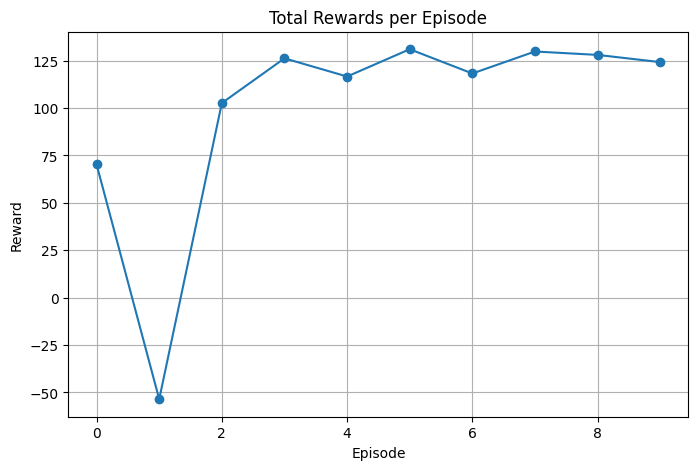

In [4]:
plt.figure(figsize=(8,5))
plt.plot(rewards, marker='o')
plt.title("Total Rewards per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.show()
